From here until the Histogram is basically loading in data and EDA. From the Histogram down is the real modeling work.

In [1]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
from causalml.inference.tree import UpliftRandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeRegressor, export_text


In [2]:
offers = pd.read_csv("/Users/michaelbrady/Downloads/archive_Starbucks/portfolio.csv")
offers.head(10)

,Unnamed: 0,reward,channels,difficulty,duration,offer_type,id
0,0,10,"['email', 'mobile', 'social']",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,1,10,"['web', 'email', 'mobile', 'social']",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,2,0,"['web', 'email', 'mobile']",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,3,5,"['web', 'email', 'mobile']",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,4,5,"['web', 'email']",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,5,3,"['web', 'email', 'mobile', 'social']",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,6,2,"['web', 'email', 'mobile', 'social']",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,7,0,"['email', 'mobile', 'social']",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,8,5,"['web', 'email', 'mobile', 'social']",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,9,2,"['web', 'email', 'mobile']",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [3]:
offers[offers["offer_type"] == "bogo"]

,Unnamed: 0,reward,channels,difficulty,duration,offer_type,id
0,0,10,"['email', 'mobile', 'social']",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,1,10,"['web', 'email', 'mobile', 'social']",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
3,3,5,"['web', 'email', 'mobile']",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
8,8,5,"['web', 'email', 'mobile', 'social']",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d


In [4]:
customers = pd.read_csv("/Users/michaelbrady/Downloads/archive_Starbucks/profile.csv")
customers

,Unnamed: 0,gender,age,id,became_member_on,income
0,0,NaN,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,2,NaN,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,4,NaN,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
...,...,...,...,...,...,...
16995,16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


In [5]:
actions = pd.read_csv("/Users/michaelbrady/Downloads/archive_Starbucks/transcript.csv")
actions.head()

,Unnamed: 0,person,event,value,time
0,0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [6]:
PREDICTION_WINDOW_HRS = 24 * 7          # 7 days
max_time          = actions["time"].max()
cutoff_time       = max_time - PREDICTION_WINDOW_HRS

# slice the historical window
actions2 = actions.copy()
offer_time = actions[actions["time"] <= cutoff_time]
after_time = actions[actions["time"] >= cutoff_time]

In [7]:
actions

,Unnamed: 0,person,event,value,time
0,0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...,...
306529,306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


In [8]:
print(customers["became_member_on"].min())
print(customers["became_member_on"].max())

20130729
20180726


In [9]:
offer_received = actions[actions["event"] == "offer received"]
offer_received["value"].value_counts()


value
{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}    7677
{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}    7668
{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}    7658
{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}    7646
{'offer id': '2906b810c7d4411798c6938adc9daaa5'}    7632
{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}    7618
{'offer id': '3f207df678b143eea3cee63160fa8bed'}    7617
{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}    7597
{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}    7593
{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}    7571
Name: count, dtype: int64

In [10]:
actions[actions["time"] == 1]

,Unnamed: 0,person,event,value,time


In [11]:
# include only customers with full demographic info (cuts out about 2000)
base = customers[customers["age"] != 118]
base["person"] = base["id"].rename("person")
base["join_date"] = base["became_member_on"].rename("join_date")
base = base.drop(columns=["id", "became_member_on"])
base.reset_index(drop=True, inplace=True)
base

/var/folders/vt/jy8dcmxj29vfz95p7lls9h1m0000gn/T/ipykernel_6373/2569486631.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base["person"] = base["id"].rename("person")
/var/folders/vt/jy8dcmxj29vfz95p7lls9h1m0000gn/T/ipykernel_6373/2569486631.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base["join_date"] = base["became_member_on"].rename("join_date")


,Unnamed: 0,gender,age,income,person,join_date
0,1,F,55,112000.0,0610b486422d4921ae7d2bf64640c50b,20170715
1,3,F,75,100000.0,78afa995795e4d85b5d9ceeca43f5fef,20170509
2,5,M,68,70000.0,e2127556f4f64592b11af22de27a7932,20180426
3,8,M,65,53000.0,389bc3fa690240e798340f5a15918d5c,20180209
4,12,M,58,51000.0,2eeac8d8feae4a8cad5a6af0499a211d,20171111
...,...,...,...,...,...,...
14820,16995,F,45,54000.0,6d5f3a774f3d4714ab0c092238f3a1d7,20180604
14821,16996,M,61,72000.0,2cb4f97358b841b9a9773a7aa05a9d77,20180713
14822,16997,M,49,73000.0,01d26f638c274aa0b965d24cefe3183f,20170126
14823,16998,F,83,50000.0,9dc1421481194dcd9400aec7c9ae6366,20160307


In [12]:
base["income"].max()

np.float64(120000.0)

In [13]:
actions.iloc[12000:12010]

,Unnamed: 0,person,event,value,time
12000,12000,c482abace7fa4ddf8266c0e5fcf19c9f,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
12001,12001,93e406d7bc0542f186e32392e53ff423,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
12002,12002,19066baab0914321ac859af0eb741c8d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0
12003,12003,a80f03b0379a404fa27ecff6028776c3,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0
12004,12004,97b1d28f6eb24c33a0c6fbbbde513593,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0
12005,12005,760786cb5e2d4df1affeb9dc6a3b8e86,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
12006,12006,b0628933a9154b31ad6293100c717127,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
12007,12007,3622ada8c6394b32a8d7ba31c737e926,offer received,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0
12008,12008,9036c74e796741abadcd03cdede004b5,offer received,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0
12009,12009,29af019fe4d542f4a2ca2e1f98e54eff,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0


In [14]:
actions["event"].value_counts()

event
transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: count, dtype: int64

In [15]:
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14825 entries, 0 to 14824
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  14825 non-null  int64  
 1   gender      14825 non-null  object 
 2   age         14825 non-null  int64  
 3   income      14825 non-null  float64
 4   person      14825 non-null  object 
 5   join_date   14825 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 695.1+ KB


In [16]:
actions["person"].isin(base["person"]).value_counts()

person
True     272762
False     33772
Name: count, dtype: int64

In [17]:
actions["event"].value_counts()

event
transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: count, dtype: int64

In [18]:
actions["value"].min()

"{'amount': 0.05}"

In [19]:
# start to aggregate events by customer
event_df = pd.crosstab(actions["person"], actions["event"]).reset_index()
event_df

event,person,offer completed,offer received,offer viewed,transaction
0,0009655768c64bdeb2e877511632db8f,3,5,4,8
1,00116118485d4dfda04fdbaba9a87b5c,0,2,2,3
2,0011e0d4e6b944f998e987f904e8c1e5,3,5,5,5
3,0020c2b971eb4e9188eac86d93036a77,3,5,3,8
4,0020ccbbb6d84e358d3414a3ff76cffd,3,4,4,12
...,...,...,...,...,...
16995,fff3ba4757bd42088c044ca26d73817a,3,6,3,11
16996,fff7576017104bcc8677a8d63322b5e1,3,5,4,6
16997,fff8957ea8b240a6b5e634b6ee8eafcf,0,3,2,5
16998,fffad4f4828548d1b5583907f2e9906b,3,4,4,12


In [20]:
# limit event columns
event_df.columns = ["person", "offer received", "offer viewed", "offer completed", "transaction"]
event_df

,person,offer received,offer viewed,offer completed,transaction
0,0009655768c64bdeb2e877511632db8f,3,5,4,8
1,00116118485d4dfda04fdbaba9a87b5c,0,2,2,3
2,0011e0d4e6b944f998e987f904e8c1e5,3,5,5,5
3,0020c2b971eb4e9188eac86d93036a77,3,5,3,8
4,0020ccbbb6d84e358d3414a3ff76cffd,3,4,4,12
...,...,...,...,...,...
16995,fff3ba4757bd42088c044ca26d73817a,3,6,3,11
16996,fff7576017104bcc8677a8d63322b5e1,3,5,4,6
16997,fff8957ea8b240a6b5e634b6ee8eafcf,0,3,2,5
16998,fffad4f4828548d1b5583907f2e9906b,3,4,4,12


In [21]:
event_df.iloc[5000:5015]

,person,offer received,offer viewed,offer completed,transaction
5000,4b1be8c2a1b74929b0afc81570a511dd,4,5,5,11
5001,4b23443348ea45c48bc162aea36a1ed2,1,6,5,17
5002,4b29c7edc4294b5b913708ea4ea2035f,0,6,2,1
5003,4b2a9054c3024ff5be7b0b7196159b62,5,6,5,22
5004,4b31e509bb5c400b9047c2c42035c0b6,4,5,3,18
5005,4b34026864b64d00ad0a5fa9d7dcdec2,2,5,4,7
5006,4b4a8aca9fce44789629a33718a4544c,0,4,1,3
5007,4b4be4fd3baf4e8b834fccd38ca81fbd,1,4,2,8
5008,4b4e9b38af2a492ebc9af02ea88a44b9,0,5,5,1
5009,4b54746836c34bc9a0db105b7d144de8,1,4,3,12


In [22]:
# limit the df to only the customers defined as "base" (full demo info)
joined_df = pd.merge(base, event_df, on="person", how="inner")
joined_df

,Unnamed: 0,gender,age,income,person,join_date,offer received,offer viewed,offer completed,transaction
0,1,F,55,112000.0,0610b486422d4921ae7d2bf64640c50b,20170715,1,2,0,3
1,3,F,75,100000.0,78afa995795e4d85b5d9ceeca43f5fef,20170509,3,4,4,7
2,5,M,68,70000.0,e2127556f4f64592b11af22de27a7932,20180426,2,4,3,3
3,8,M,65,53000.0,389bc3fa690240e798340f5a15918d5c,20180209,5,6,6,3
4,12,M,58,51000.0,2eeac8d8feae4a8cad5a6af0499a211d,20171111,1,3,2,4
...,...,...,...,...,...,...,...,...,...,...
14820,16995,F,45,54000.0,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,0,3,3,7
14821,16996,M,61,72000.0,2cb4f97358b841b9a9773a7aa05a9d77,20180713,1,3,1,7
14822,16997,M,49,73000.0,01d26f638c274aa0b965d24cefe3183f,20170126,0,3,1,8
14823,16998,F,83,50000.0,9dc1421481194dcd9400aec7c9ae6366,20160307,3,3,3,14


In [23]:
actions.shape

(306534, 5)

In [24]:
actions

,Unnamed: 0,person,event,value,time
0,0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...,...
306529,306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


In [25]:
# ensure value is a dict
actions['value'] = actions['value'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# extract 'offer_id' from the 'value' dictionary
actions['offer_id'] = actions['value'].apply(lambda x: x.get('offer id') if isinstance(x, dict) else None)

# filter to only 'offer received' events
received_df = actions[actions['event'] == 'offer received']

# merge with offer data
received_df = received_df.merge(offers[['id', 'offer_type']], left_on='offer_id', right_on='id', how='left')
received_df = received_df.drop(columns='id')

# count how many of each offer_type were sent to each person
offer_counts = received_df.groupby(['person', 'offer_type']).size().unstack(fill_value=0)



In [26]:
offer_counts

offer_type,bogo,discount,informational
person,,,
0009655768c64bdeb2e877511632db8f,1,2,2
00116118485d4dfda04fdbaba9a87b5c,2,0,0
0011e0d4e6b944f998e987f904e8c1e5,1,2,2
0020c2b971eb4e9188eac86d93036a77,2,2,1
0020ccbbb6d84e358d3414a3ff76cffd,2,1,1
...,...,...,...
fff3ba4757bd42088c044ca26d73817a,1,3,2
fff7576017104bcc8677a8d63322b5e1,3,2,0
fff8957ea8b240a6b5e634b6ee8eafcf,1,1,1


In [27]:
joined_df = pd.merge(joined_df, offer_counts, on="person", how="inner")
joined_df

,Unnamed: 0,gender,age,income,person,join_date,offer received,offer viewed,offer completed,transaction,bogo,discount,informational
0,1,F,55,112000.0,0610b486422d4921ae7d2bf64640c50b,20170715,1,2,0,3,1,0,1
1,3,F,75,100000.0,78afa995795e4d85b5d9ceeca43f5fef,20170509,3,4,4,7,3,0,1
2,5,M,68,70000.0,e2127556f4f64592b11af22de27a7932,20180426,2,4,3,3,1,2,1
3,8,M,65,53000.0,389bc3fa690240e798340f5a15918d5c,20180209,5,6,6,3,4,2,0
4,12,M,58,51000.0,2eeac8d8feae4a8cad5a6af0499a211d,20171111,1,3,2,4,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14815,16995,F,45,54000.0,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,0,3,3,7,1,1,1
14816,16996,M,61,72000.0,2cb4f97358b841b9a9773a7aa05a9d77,20180713,1,3,1,7,1,0,2
14817,16997,M,49,73000.0,01d26f638c274aa0b965d24cefe3183f,20170126,0,3,1,8,0,1,2
14818,16998,F,83,50000.0,9dc1421481194dcd9400aec7c9ae6366,20160307,3,3,3,14,3,0,0


In [28]:
# filter to transaction events
transaction_df = actions[actions['event'] == 'transaction'].copy()

# extract total amount
transaction_df['amount'] = transaction_df['value'].apply(lambda x: x.get('amount') if isinstance(x, dict) else None)

# group by person and sum
total_spend = transaction_df.groupby('person')['amount'].sum()

In [29]:
joined_df = pd.merge(joined_df, total_spend, on="person", how="inner")
joined_df

,Unnamed: 0,gender,age,income,person,join_date,offer received,offer viewed,offer completed,transaction,bogo,discount,informational,amount
0,1,F,55,112000.0,0610b486422d4921ae7d2bf64640c50b,20170715,1,2,0,3,1,0,1,77.01
1,3,F,75,100000.0,78afa995795e4d85b5d9ceeca43f5fef,20170509,3,4,4,7,3,0,1,159.27
2,5,M,68,70000.0,e2127556f4f64592b11af22de27a7932,20180426,2,4,3,3,1,2,1,57.73
3,8,M,65,53000.0,389bc3fa690240e798340f5a15918d5c,20180209,5,6,6,3,4,2,0,36.43
4,12,M,58,51000.0,2eeac8d8feae4a8cad5a6af0499a211d,20171111,1,3,2,4,0,2,1,15.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14482,16995,F,45,54000.0,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,0,3,3,7,1,1,1,20.03
14483,16996,M,61,72000.0,2cb4f97358b841b9a9773a7aa05a9d77,20180713,1,3,1,7,1,0,2,25.97
14484,16997,M,49,73000.0,01d26f638c274aa0b965d24cefe3183f,20170126,0,3,1,8,0,1,2,39.74
14485,16998,F,83,50000.0,9dc1421481194dcd9400aec7c9ae6366,20160307,3,3,3,14,3,0,0,189.67


Below is where the uplift design started to come together around the target of 7-day conversion, i.e. Did the customer purchase at least once in the next 7 days?

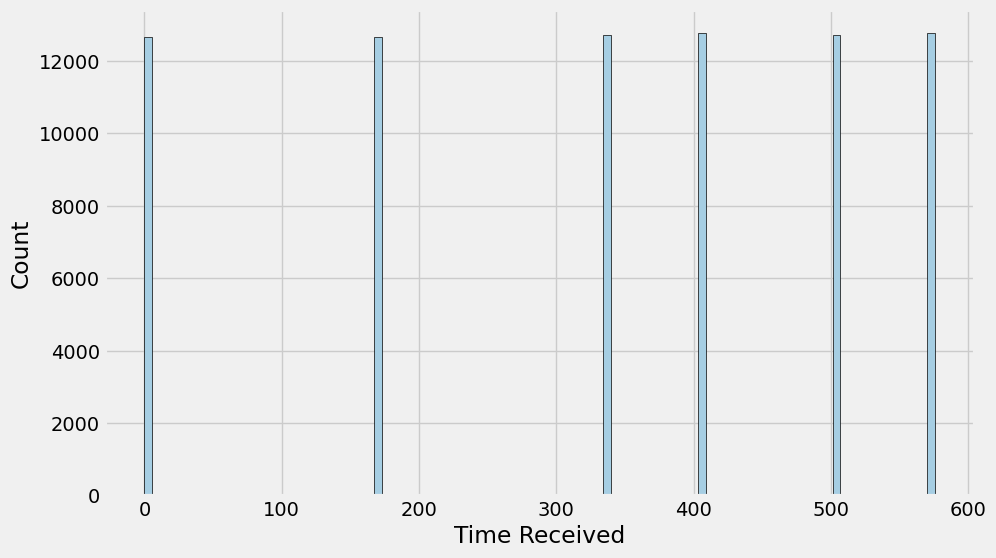

In [30]:
# visualize the offer send
plt.figure(figsize=(10,6))
plt.hist(offer_received["time"], bins=100, edgecolor='k')
plt.xlabel("Time Received")
plt.ylabel("Count")
plt.show()


In [31]:
# get offer send times
unique_times = offer_received["time"].unique()
print(sorted(unique_times))


[np.int64(0), np.int64(168), np.int64(336), np.int64(408), np.int64(504), np.int64(576)]


In [32]:
# get all customers, filter to "base" later
all_customers = set(actions["person"].unique())
len(all_customers)


17000

In [33]:
# define the whole of the population (minus the control)
received_at_168 = set(
    actions[
        (actions["event"] == "offer received") & (actions["time"] == 168)
    ]["person"]
)
len(received_at_168)

12669

In [34]:
# define the control
no_offer_at_168 = all_customers - received_at_168
len(no_offer_at_168)

4331

In [35]:
no_offer_df = pd.DataFrame(list(no_offer_at_168), columns=["person"])
no_offer_df

,person
0,54eaf9f5ddc04ce6a91d8385bb0a8d17
1,8c17a1d5a98343ebac53d9aac99aeb42
2,46eb2598375a4042bf31580470ea36f9
3,154dfaa196014a438640028a7e4101d4
4,46c1046acb4b4f29840ba3d55ba5682d
...,...
4326,756418e9da164ec9bd7af9886df13d2a
4327,a305233f5c944df5bcaacc029658e085
4328,67c19b4c8145412b8c89528d6e1d36f1
4329,ae56c4d76ac84a639a31693086044dd9


In [36]:
# population who made a purchase during 7 days following offer
purchase_next_week = set(actions[
    (actions["event"] == "transaction") &
    (actions["time"] > 168) & (actions["time"] <= 336)
]["person"])
len(purchase_next_week)

12753

In [37]:
# RECEIVED group: who made a purchase
purchased_received = set(purchase_next_week) & received_at_168

# NO OFFER group: who made a purchase
purchased_no_offer = set(purchase_next_week) & no_offer_at_168

print(f"Offer received group: {len(purchased_received)} made a purchase")
print(f"No offer group: {len(purchased_no_offer)} made a purchase")


Offer received group: 9927 made a purchase
No offer group: 2826 made a purchase


In [38]:
conversion_received = len(purchased_received) / len(received_at_168)
conversion_no_offer = len(purchased_no_offer) / len(no_offer_at_168)

print(f"Offer received group conversion: {conversion_received:.2%}")
print(f"No offer group conversion: {conversion_no_offer:.2%}")


Offer received group conversion: 78.36%
No offer group conversion: 65.25%


In [39]:
# treatment cohort — every event for the people who got the offer
df_treat = actions[actions["person"].isin(received_at_168)].copy()

# control cohort — every event for the people who didn’t
df_control = actions[actions["person"].isin(no_offer_at_168)].copy()
df_control

,Unnamed: 0,person,event,value,time,offer_id
1,1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5
6,6,c4863c7985cf408faee930f111475da3,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0,2298d6c36e964ae4a3e7e9706d1fb8c2
11,11,3d02345581554e81b7b289ab5e288078,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7
14,14,d53717f5400c4e84affdaeda9dd926b3,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7
...,...,...,...,...,...,...
306527,306527,24f56b5e1849462093931b164eb803b5,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,714,None
306528,306528,5ca2620962114246ab218fc648eb3934,transaction,{'amount': 2.2},714,None
306529,306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714,None
306532,306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714,None


In [40]:
# double check the control group
control_check = (df_control["event"] == "offer received") & (df_control["time"] == 168)
df_control[control_check]

,Unnamed: 0,person,event,value,time,offer_id


In [41]:
# double check the treatment group
treat_check = (df_treat["event"] == "offer received") & (df_treat["time"] == 168)
df_treat[treat_check]

,Unnamed: 0,person,event,value,time,offer_id
53174,53174,68be06ca386d4c31939f3a4f0e3dd783,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},168,2906b810c7d4411798c6938adc9daaa5
53175,53175,38fe809add3b4fcf9315a9694bb96ff5,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},168,9b98b8c7a33c4b65b9aebfe6a799e6d9
53176,53176,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168,5a8bc65990b245e5a138643cd4eb9837
53177,53177,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},168,4d5c57ea9a6940dd891ad53e9dbe8da0
53178,53178,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},168,ae264e3637204a6fb9bb56bc8210ddfd
...,...,...,...,...,...,...
65838,65838,670626b55bfb4ba39c85b27cc7cca527,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168,5a8bc65990b245e5a138643cd4eb9837
65839,65839,79edb810789c447e8d212a324b44cc16,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},168,3f207df678b143eea3cee63160fa8bed
65840,65840,f924927e7f844ecebf87eef93f4d2688,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},168,2906b810c7d4411798c6938adc9daaa5
65841,65841,d087c473b4d247ccb0abfef59ba12b0e,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},168,9b98b8c7a33c4b65b9aebfe6a799e6d9


In [42]:
# define time window
SNAPSHOT = 168
LOOKBACK = 168

In [43]:
# filter the raw log to the history window
hist = actions[
    (actions["event"] == "transaction") &
    (actions["time"] >= SNAPSHOT - LOOKBACK) &
    (actions["time"] <  SNAPSHOT)
]

# recency = hours since last txn (lower is fresher)
recency_df = (
    hist.groupby("person")["time"]
        .max()
        .rsub(SNAPSHOT)            # SNAPSHOT - last_txn_time
        .rename("recency")
)

# frequency = transactions in lookback window
freq_df = (
    hist.groupby("person")["time"]
        .size()
        .rename("frequency")
)

rf = (
    pd.concat([recency_df, freq_df], axis=1)
      .reindex(actions["person"].unique())   # include people w/ no history
      .fillna({"recency": SNAPSHOT, "frequency": 0})
      .reset_index()
)


In [44]:
rf.iloc[900:905]

,person,recency,frequency
900,d558b038136e4474a94ac2bb0a67efc9,6.0,2.0
901,cbecec5803434d63bce1e4c451d4b2d7,168.0,0.0
902,593c3cd7ab1e4a10a6f9279544da7df3,168.0,0.0
903,5ec47474a7244d7c8be5d44e99c39c35,168.0,0.0
904,15f68a59b74546f892bd9f277c9a42ae,24.0,9.0


In [45]:
# get treatment-labeled dataframe in order
labels = pd.DataFrame({
    "person": list(received_at_168 | no_offer_at_168),
})
labels["treatment"] = labels["person"].isin(received_at_168).astype(int)

# add recency & frequency
labels = labels.merge(rf, on="person", how="left")


In [46]:
labels

,person,treatment,recency,frequency
0,eeb598ca6cc14ea483e1efb0ae419dd8,1,18.0,3.0
1,b0628933a9154b31ad6293100c717127,1,168.0,0.0
2,c7c7c87a97a04536b8c7f5a5e386935a,1,102.0,2.0
3,588ef63b83604b9985a4d90f5033fe86,1,36.0,2.0
4,5565f2c4d97543038e81496ae63255ed,1,168.0,0.0
...,...,...,...,...
16995,756418e9da164ec9bd7af9886df13d2a,0,66.0,1.0
16996,240eaede0a3c438ca9e85bfcc2fac550,1,54.0,4.0
16997,29b2d42d18e24a68960fdd073d95fb48,1,102.0,3.0
16998,35075a458f4043c8bdd3dc33c728826b,1,18.0,2.0


In [47]:
actions = actions.copy()
actions["offer_id"] = actions["value"].apply(
    lambda x: x.get("offer id") if isinstance(x, dict) else np.nan
)

In [48]:
actions = actions.merge(
    offers.rename(columns={"id": "offer_id"}),
    on="offer_id",
    how="left"
)


In [49]:
actions

,Unnamed: 0_x,person,event,value,time,offer_id,Unnamed: 0_y,reward,channels,difficulty,duration,offer_type
0,0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,3.0,5.0,"['web', 'email', 'mobile']",5.0,7.0,bogo
1,1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,4.0,5.0,"['web', 'email']",20.0,10.0,discount
2,2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,9.0,2.0,"['web', 'email', 'mobile']",10.0,7.0,discount
3,3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,6.0,2.0,"['web', 'email', 'mobile', 'social']",10.0,10.0,discount
4,4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,1.0,10.0,"['web', 'email', 'mobile', 'social']",10.0,5.0,bogo
...,...,...,...,...,...,...,...,...,...,...,...,...
306529,306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714,None,NaN,NaN,NaN,NaN,NaN,NaN
306530,306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714,None,NaN,NaN,NaN,NaN,NaN,NaN
306531,306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714,None,NaN,NaN,NaN,NaN,NaN,NaN
306532,306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714,None,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
# keep only the "base" customers
labels = labels.merge(
    base,    
    on="person",
    how="inner"
)
labels

,person,treatment,recency,frequency,Unnamed: 0,gender,age,income,join_date
0,eeb598ca6cc14ea483e1efb0ae419dd8,1,18.0,3.0,9573,F,48,38000.0,20160402
1,b0628933a9154b31ad6293100c717127,1,168.0,0.0,1953,M,69,51000.0,20180429
2,c7c7c87a97a04536b8c7f5a5e386935a,1,102.0,2.0,5299,F,40,61000.0,20160501
3,588ef63b83604b9985a4d90f5033fe86,1,36.0,2.0,4969,F,32,48000.0,20151208
4,5565f2c4d97543038e81496ae63255ed,1,168.0,0.0,5849,M,48,45000.0,20180625
...,...,...,...,...,...,...,...,...,...
14820,756418e9da164ec9bd7af9886df13d2a,0,66.0,1.0,8123,F,76,109000.0,20170317
14821,240eaede0a3c438ca9e85bfcc2fac550,1,54.0,4.0,4172,F,58,42000.0,20151117
14822,29b2d42d18e24a68960fdd073d95fb48,1,102.0,3.0,16899,M,50,54000.0,20180127
14823,35075a458f4043c8bdd3dc33c728826b,1,18.0,2.0,11093,M,60,33000.0,20161229


In [51]:
# get metadata for offers (ended up not using)
treat_meta = (
    actions.loc[
        (actions["event"] == "offer received") & (actions["time"] == 168),
        ["person", "offer_type", "difficulty", "reward"]
    ]
    .drop_duplicates("person") 
)

labels = labels.merge(treat_meta, on="person", how="left")   # control rows → NaN

In [52]:
labels

,person,treatment,recency,frequency,Unnamed: 0,gender,age,income,join_date,offer_type,difficulty,reward
0,eeb598ca6cc14ea483e1efb0ae419dd8,1,18.0,3.0,9573,F,48,38000.0,20160402,discount,20.0,5.0
1,b0628933a9154b31ad6293100c717127,1,168.0,0.0,1953,M,69,51000.0,20180429,bogo,10.0,10.0
2,c7c7c87a97a04536b8c7f5a5e386935a,1,102.0,2.0,5299,F,40,61000.0,20160501,bogo,5.0,5.0
3,588ef63b83604b9985a4d90f5033fe86,1,36.0,2.0,4969,F,32,48000.0,20151208,bogo,10.0,10.0
4,5565f2c4d97543038e81496ae63255ed,1,168.0,0.0,5849,M,48,45000.0,20180625,bogo,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
14820,756418e9da164ec9bd7af9886df13d2a,0,66.0,1.0,8123,F,76,109000.0,20170317,NaN,NaN,NaN
14821,240eaede0a3c438ca9e85bfcc2fac550,1,54.0,4.0,4172,F,58,42000.0,20151117,discount,10.0,2.0
14822,29b2d42d18e24a68960fdd073d95fb48,1,102.0,3.0,16899,M,50,54000.0,20180127,bogo,10.0,10.0
14823,35075a458f4043c8bdd3dc33c728826b,1,18.0,2.0,11093,M,60,33000.0,20161229,informational,0.0,0.0


In [53]:
# purchase flag equals 1 if purchase made in next ten days
purchase_flag = (
    actions.loc[
        (actions["event"] == "transaction") &
        (actions["time"] > SNAPSHOT) &
        (actions["time"] <= SNAPSHOT + 240),
        ["person"]
    ]
    .assign(purchase_next_week=1)
    .drop_duplicates()
)

# merge everything
labels = (
    pd.DataFrame({"person": list(received_at_168 | no_offer_at_168)})
      .assign(treatment=lambda d: d["person"].isin(received_at_168).astype(int))
      .merge(rf, on="person", how="left")
      .merge(base, on="person", how="left")           # demographics
      .merge(purchase_flag, on="person", how="left")
      .fillna({"purchase_next_week": 0})
)

labels = (labels
          .merge(treat_meta, on="person", how="left")
          .fillna({"offer_type": "no_offer",
                   "difficulty": 0,
                   "reward": 0,
                   "duration": 0,
                   "channels": "none"}))

labels['treatment'].value_counts()

treatment
1    12669
0     4331
Name: count, dtype: int64

In [54]:
# clean up age and gender
labels = labels.dropna(subset=["age"])

labels = pd.get_dummies(labels, columns=['gender'], drop_first=True).drop(columns="gender_O")

labels

,person,treatment,recency,frequency,Unnamed: 0,age,income,join_date,purchase_next_week,offer_type,difficulty,reward,gender_M
0,eeb598ca6cc14ea483e1efb0ae419dd8,1,18.0,3.0,9573.0,48.0,38000.0,20160402.0,1.0,discount,20.0,5.0,False
1,b0628933a9154b31ad6293100c717127,1,168.0,0.0,1953.0,69.0,51000.0,20180429.0,1.0,bogo,10.0,10.0,True
2,c7c7c87a97a04536b8c7f5a5e386935a,1,102.0,2.0,5299.0,40.0,61000.0,20160501.0,1.0,bogo,5.0,5.0,False
3,588ef63b83604b9985a4d90f5033fe86,1,36.0,2.0,4969.0,32.0,48000.0,20151208.0,1.0,bogo,10.0,10.0,False
4,5565f2c4d97543038e81496ae63255ed,1,168.0,0.0,5849.0,48.0,45000.0,20180625.0,1.0,bogo,5.0,5.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16995,756418e9da164ec9bd7af9886df13d2a,0,66.0,1.0,8123.0,76.0,109000.0,20170317.0,1.0,no_offer,0.0,0.0,False
16996,240eaede0a3c438ca9e85bfcc2fac550,1,54.0,4.0,4172.0,58.0,42000.0,20151117.0,1.0,discount,10.0,2.0,False
16997,29b2d42d18e24a68960fdd073d95fb48,1,102.0,3.0,16899.0,50.0,54000.0,20180127.0,1.0,bogo,10.0,10.0,True
16998,35075a458f4043c8bdd3dc33c728826b,1,18.0,2.0,11093.0,60.0,33000.0,20161229.0,1.0,informational,0.0,0.0,True


In [55]:
ate = (labels.loc[labels["treatment"]==1, "purchase_next_week"].mean() -
       labels.loc[labels["treatment"]==0, "purchase_next_week"].mean())
print(f"Raw diff-in-means ATE: {ate:.3%}")


Raw diff-in-means ATE: 5.446%


In [56]:
# compare average recency/frequency in treatment vs control to be sure treatment is random
for col in ["recency", "frequency"]:
    mean_t = labels.loc[labels["treatment"]==1, col].mean()
    mean_c = labels.loc[labels["treatment"]==0, col].mean()
    print(f"{col}: Treatment mean = {mean_t:.2f}, Control mean = {mean_c:.2f}")


recency: Treatment mean = 97.34, Control mean = 98.72
frequency: Treatment mean = 1.58, Control mean = 1.54


In [57]:
#seperate offer types for analysis and modeling
bogo = labels.loc[labels["offer_type"] == "bogo"]
discount = labels.loc[labels["offer_type"] == "discount"]
informational = labels.loc[labels["offer_type"] == "informational"]
control = labels.loc[labels["offer_type"] == "no_offer"]
bogo = pd.concat([bogo, control])
discount = pd.concat([discount, control])
informational = pd.concat([informational, control])
bogo

,person,treatment,recency,frequency,Unnamed: 0,age,income,join_date,purchase_next_week,offer_type,difficulty,reward,gender_M
1,b0628933a9154b31ad6293100c717127,1,168.0,0.0,1953.0,69.0,51000.0,20180429.0,1.0,bogo,10.0,10.0,True
2,c7c7c87a97a04536b8c7f5a5e386935a,1,102.0,2.0,5299.0,40.0,61000.0,20160501.0,1.0,bogo,5.0,5.0,False
3,588ef63b83604b9985a4d90f5033fe86,1,36.0,2.0,4969.0,32.0,48000.0,20151208.0,1.0,bogo,10.0,10.0,False
4,5565f2c4d97543038e81496ae63255ed,1,168.0,0.0,5849.0,48.0,45000.0,20180625.0,1.0,bogo,5.0,5.0,True
6,034ce97360c6485ab990d903343f9f08,1,168.0,0.0,2365.0,23.0,48000.0,20180712.0,1.0,bogo,5.0,5.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16983,cb1e075f874b488a81995ea4dc3e12fe,0,54.0,4.0,4343.0,50.0,56000.0,20151017.0,1.0,no_offer,0.0,0.0,True
16985,c7c10633e725437cbee376c8c57c8d11,0,36.0,1.0,15234.0,66.0,53000.0,20161105.0,1.0,no_offer,0.0,0.0,True
16989,37c5d270f84c4a4ca153b617d0523782,0,168.0,0.0,8881.0,56.0,76000.0,20180227.0,0.0,no_offer,0.0,0.0,False
16995,756418e9da164ec9bd7af9886df13d2a,0,66.0,1.0,8123.0,76.0,109000.0,20170317.0,1.0,no_offer,0.0,0.0,False


In [58]:
control["frequency"].value_counts(normalize=True)

frequency
0.0     0.329171
1.0     0.276302
2.0     0.176142
3.0     0.097237
4.0     0.055260
5.0     0.027630
6.0     0.020988
7.0     0.009564
8.0     0.003188
9.0     0.002125
10.0    0.001063
12.0    0.000797
11.0    0.000531
Name: proportion, dtype: float64

In [59]:
control.head(20)

,person,treatment,recency,frequency,Unnamed: 0,age,income,join_date,purchase_next_week,offer_type,difficulty,reward,gender_M
7,1c915596914b4931b6dd2386601ae325,0,168.0,0.0,3864.0,54.0,35000.0,20180429.0,1.0,no_offer,0.0,0.0,True
12,01925607d99c460996c281f17cdbb9e2,0,168.0,0.0,8471.0,57.0,116000.0,20151119.0,1.0,no_offer,0.0,0.0,False
13,76e4c32f141f4bd1b1a905cf6b28bcfa,0,168.0,0.0,7094.0,60.0,104000.0,20170508.0,0.0,no_offer,0.0,0.0,False
14,a80ed01ca0f14e49bde53fb7a175faa4,0,48.0,1.0,7389.0,60.0,113000.0,20170807.0,0.0,no_offer,0.0,0.0,False
15,ccb81c7706fa46b692d357a2098fdfb1,0,168.0,0.0,7518.0,62.0,52000.0,20170924.0,1.0,no_offer,0.0,0.0,True
17,3332985e282b4de49efb1becced8d9cb,0,168.0,0.0,15361.0,53.0,53000.0,20150521.0,1.0,no_offer,0.0,0.0,False
32,3c55dbc0fe1a487c9743dfa6170d20e8,0,114.0,3.0,2611.0,24.0,32000.0,20171203.0,1.0,no_offer,0.0,0.0,True
44,72dd638d5a1d4f1f8fc4e99d0859f8a9,0,12.0,2.0,11428.0,43.0,73000.0,20160927.0,1.0,no_offer,0.0,0.0,True
46,8456266c53894990829027cd1ea102ad,0,168.0,0.0,15682.0,49.0,75000.0,20180501.0,1.0,no_offer,0.0,0.0,False
47,aedba933c467488a82f5b83fa981ef8a,0,168.0,0.0,5117.0,43.0,84000.0,20170114.0,1.0,no_offer,0.0,0.0,False


In [60]:
# set up columns and targets for first UPLIFT MODEL
feature_cols = ["recency", "frequency", "age", "income", "gender_M", "join_date"]

X = bogo[feature_cols]
y = bogo["purchase_next_week"]
w = bogo["treatment"]
w = w.replace({0: 'control', 1: 'treatment'})


In [61]:
# train and predict UPLIFT MODEL
uplift_rf = UpliftRandomForestClassifier(
    n_estimators=200,
    max_depth=5,
    min_samples_leaf=200,
    evaluationFunction='KL',
    control_name="control"  # <- NOT optional
)

uplift_rf.fit(X.values, treatment=w.values, y=y.values)

cate_preds = uplift_rf.predict(X.values)


In [62]:
# assign uplift predictions as %
bogo_preds = bogo.copy()
bogo_preds["preds"] = cate_preds
bogo_preds

,person,treatment,recency,frequency,Unnamed: 0,age,income,join_date,purchase_next_week,offer_type,difficulty,reward,gender_M,preds
1,b0628933a9154b31ad6293100c717127,1,168.0,0.0,1953.0,69.0,51000.0,20180429.0,1.0,bogo,10.0,10.0,True,0.019295
2,c7c7c87a97a04536b8c7f5a5e386935a,1,102.0,2.0,5299.0,40.0,61000.0,20160501.0,1.0,bogo,5.0,5.0,False,0.068005
3,588ef63b83604b9985a4d90f5033fe86,1,36.0,2.0,4969.0,32.0,48000.0,20151208.0,1.0,bogo,10.0,10.0,False,0.066133
4,5565f2c4d97543038e81496ae63255ed,1,168.0,0.0,5849.0,48.0,45000.0,20180625.0,1.0,bogo,5.0,5.0,True,0.024319
6,034ce97360c6485ab990d903343f9f08,1,168.0,0.0,2365.0,23.0,48000.0,20180712.0,1.0,bogo,5.0,5.0,True,0.063478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16983,cb1e075f874b488a81995ea4dc3e12fe,0,54.0,4.0,4343.0,50.0,56000.0,20151017.0,1.0,no_offer,0.0,0.0,True,0.065830
16985,c7c10633e725437cbee376c8c57c8d11,0,36.0,1.0,15234.0,66.0,53000.0,20161105.0,1.0,no_offer,0.0,0.0,True,0.052805
16989,37c5d270f84c4a4ca153b617d0523782,0,168.0,0.0,8881.0,56.0,76000.0,20180227.0,0.0,no_offer,0.0,0.0,False,0.032234
16995,756418e9da164ec9bd7af9886df13d2a,0,66.0,1.0,8123.0,76.0,109000.0,20170317.0,1.0,no_offer,0.0,0.0,False,0.098620


In [63]:
bogo_preds = bogo_preds.sort_values(by="preds", ascending=False)
bogo_preds.head(20)

,person,treatment,recency,frequency,Unnamed: 0,age,income,join_date,purchase_next_week,offer_type,difficulty,reward,gender_M,preds
14769,71a5dd25d3704dafa598b9cc2ca7028a,0,168.0,0.0,11901.0,68.0,104000.0,20161016.0,1.0,no_offer,0.0,0.0,False,0.219009
2987,29655cba61a04d079efde18203b4f232,1,168.0,0.0,14281.0,67.0,101000.0,20161017.0,1.0,bogo,5.0,5.0,False,0.218432
15340,e4c1df33299b4b9d9d8924a45823095d,1,168.0,0.0,7489.0,61.0,113000.0,20161105.0,1.0,bogo,5.0,5.0,False,0.217575
12966,40bc3cf593394618b90f6d79e198867a,0,168.0,0.0,3101.0,64.0,109000.0,20161112.0,0.0,no_offer,0.0,0.0,False,0.217566
4014,546267273d6041f48946369c65c11531,1,168.0,0.0,8911.0,62.0,103000.0,20161213.0,1.0,bogo,10.0,10.0,True,0.217555
3283,3c9afb70b2cb42a1ac2e5ff8cdc5be29,1,168.0,0.0,16535.0,63.0,99000.0,20160824.0,1.0,bogo,10.0,10.0,True,0.217235
14203,7d2f4592e232437d92e875ba21c03bc4,1,168.0,0.0,5691.0,59.0,98000.0,20161205.0,1.0,bogo,5.0,5.0,False,0.216850
14504,abc210958d314238bbea0baf7086d613,0,168.0,0.0,4635.0,69.0,114000.0,20160909.0,0.0,no_offer,0.0,0.0,False,0.215902
8210,430f2cedb60c4585bda4c36106db73d5,1,168.0,0.0,15397.0,63.0,95000.0,20161122.0,1.0,bogo,10.0,10.0,False,0.215706
14064,6fc4b2ee5d844566aafeaa209fe11de1,1,168.0,0.0,13937.0,67.0,97000.0,20161023.0,1.0,bogo,5.0,5.0,True,0.214731


In [64]:
# logistic regression model as PROPENSITY CHECK
feature_cols = ["recency", "frequency", "age", "income", "gender_M", "join_date"]

X  = bogo_preds[feature_cols]
w  = bogo_preds["treatment"]

prop_model = LogisticRegression(max_iter=500)
prop_model.fit(X[feature_cols], w)
p_scores = prop_model.predict_proba(X[feature_cols])[:, 1]

auc = roc_auc_score(w, p_scores)
print(f"Propensity-model AUC  (0.5=random,1.0=perfect):  {auc:.3f}")


Propensity-model AUC  (0.5=random,1.0=perfect):  0.512


In [65]:
# fit "explainer tree" to cate_preds
explainer_tree = DecisionTreeRegressor(max_depth=3)
explainer_tree.fit(X, cate_preds)

# print the decision rules
print(export_text(explainer_tree, feature_names=list(X.columns)))


|--- join_date <= 20131114.00
|   |--- age <= 68.50
|   |   |--- age <= 57.50
|   |   |   |--- value: [0.08]
|   |   |--- age >  57.50
|   |   |   |--- value: [0.11]
|   |--- age >  68.50
|   |   |--- income <= 75000.00
|   |   |   |--- value: [0.05]
|   |   |--- income >  75000.00
|   |   |   |--- value: [0.10]
|--- join_date >  20131114.00
|   |--- income <= 102500.00
|   |   |--- age <= 85.50
|   |   |   |--- value: [0.07]
|   |   |--- age >  85.50
|   |   |   |--- value: [0.07]
|   |--- income >  102500.00
|   |   |--- age <= 64.50
|   |   |   |--- value: [0.07]
|   |   |--- age >  64.50
|   |   |   |--- value: [0.08]



In [66]:
# feature importances
for col, imp in zip(X.columns, uplift_rf.feature_importances_):
    print(f"{col:<30}: {imp:.4f}")


recency                       : 0.1185
frequency                     : 0.0823
age                           : 0.1628
income                        : 0.1601
gender_M                      : 0.0373
join_date                     : 0.4391


In [67]:
# quick correlation check
labels[["age","income"]].corr()

# slice observed uplift by age quartile
labels["age_band"] = pd.qcut(labels["age"], 4)
observed_uplift = labels.groupby("age_band").apply(
    lambda g: g[g.treatment==1].purchase_next_week.mean() -
              g[g.treatment==0].purchase_next_week.mean())
print(observed_uplift)


age_band
(17.999, 42.0]    0.060428
(42.0, 55.0]      0.060145
(55.0, 66.0]      0.049932
(66.0, 101.0]     0.047878
dtype: float64


/var/folders/vt/jy8dcmxj29vfz95p7lls9h1m0000gn/T/ipykernel_6373/2577982553.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  observed_uplift = labels.groupby("age_band").apply(
/var/folders/vt/jy8dcmxj29vfz95p7lls9h1m0000gn/T/ipykernel_6373/2577982553.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  observed_uplift = labels.groupby("age_band").apply(


In [68]:
feature_cols = ["recency", "frequency", "age", "income", "gender_M", "join_date"]

X = discount[feature_cols]
y = discount["purchase_next_week"]
w = discount["treatment"]
w = w.replace({0: 'control', 1: 'treatment'})


uplift_rf = UpliftRandomForestClassifier(
    n_estimators=200,
    max_depth=5,
    min_samples_leaf=200,
    evaluationFunction='KL',
    control_name="control"  # <- NOT optional
)

uplift_rf.fit(X.values, treatment=w.values, y=y.values)

cate_preds = uplift_rf.predict(X.values)




In [69]:
discount_preds = discount.copy()
discount_preds["preds"] = cate_preds
discount_preds = discount_preds.sort_values(by="preds", ascending=False)


In [70]:
discount_preds.iloc[100:126]

,person,treatment,recency,frequency,Unnamed: 0,age,income,join_date,purchase_next_week,offer_type,difficulty,reward,gender_M,preds
7698,90c964405bd74fa68a29af133eabe0ba,1,168.0,0.0,7239.0,77.0,113000.0,20170306.0,1.0,discount,7.0,3.0,False,0.197084
15001,428111c5138a4a4c8131e5d2f258fa95,0,168.0,0.0,4424.0,56.0,104000.0,20160602.0,1.0,no_offer,0.0,0.0,False,0.196883
805,b39221039ef04377844775f6b116b40d,1,168.0,0.0,11688.0,53.0,97000.0,20160108.0,1.0,discount,10.0,2.0,True,0.196840
4195,496ac7798e9d49e68468823dad0f43df,0,168.0,0.0,1897.0,86.0,90000.0,20160528.0,1.0,no_offer,0.0,0.0,True,0.196745
280,1e8555612cf545938953a8a648705185,1,168.0,0.0,7498.0,53.0,104000.0,20161209.0,1.0,discount,7.0,3.0,False,0.196720
14620,8c54f6657313449b9f78e1f6b7a17aa9,1,168.0,0.0,5349.0,83.0,90000.0,20160804.0,1.0,discount,7.0,3.0,True,0.196704
14510,1ffbfe62d38f4a0ebae49a79b1dd8601,1,168.0,0.0,7645.0,73.0,110000.0,20170717.0,1.0,discount,20.0,5.0,True,0.196698
7323,187bc1f183174e6799994488d7b2bf2b,0,168.0,0.0,8493.0,91.0,95000.0,20160820.0,0.0,no_offer,0.0,0.0,False,0.196664
4696,ba4fff69b9224b87a1916f9fd9d0c2c8,1,168.0,0.0,3635.0,75.0,109000.0,20170514.0,1.0,discount,10.0,2.0,False,0.196549
6547,eaaa456d803e49798017100b16fda6c5,1,168.0,0.0,448.0,66.0,94000.0,20161204.0,0.0,discount,20.0,5.0,False,0.196405


In [71]:
for col, imp in zip(X.columns, uplift_rf.feature_importances_):
    print(f"{col:<30}: {imp:.4f}")

recency                       : 0.0900
frequency                     : 0.0744
age                           : 0.1640
income                        : 0.1082
gender_M                      : 0.0279
join_date                     : 0.5355


In [72]:
feature_cols = ["recency", "frequency", "age", "income", "gender_M", "join_date"]

X = informational[feature_cols]
y = informational["purchase_next_week"]
w = informational["treatment"]
w = w.replace({0: 'control', 1: 'treatment'})


uplift_rf = UpliftRandomForestClassifier(
    n_estimators=200,
    max_depth=6,
    min_samples_leaf=200,
    evaluationFunction='KL',
    control_name="control"  # <- NOT optional
)

uplift_rf.fit(X.values, treatment=w.values, y=y.values)

cate_preds = uplift_rf.predict(X.values)



In [73]:
informational_preds = informational.copy()
informational_preds["preds"] = cate_preds
informational_preds = informational_preds.sort_values(by="preds", ascending=False)
informational_preds.iloc[-20:]


,person,treatment,recency,frequency,Unnamed: 0,age,income,join_date,purchase_next_week,offer_type,difficulty,reward,gender_M,preds
6906,96604dd4f8a94c1b90e9137e5046c9bd,0,168.0,0.0,9105.0,44.0,62000.0,20180506.0,1.0,no_offer,0.0,0.0,False,-0.103344
5911,4b4e9b38af2a492ebc9af02ea88a44b9,1,168.0,0.0,16769.0,48.0,60000.0,20180516.0,0.0,informational,0.0,0.0,False,-0.103362
12421,4767f009712f47e2a60cf75bd1de8175,1,84.0,1.0,9072.0,44.0,98000.0,20180725.0,1.0,informational,0.0,0.0,False,-0.103957
192,482ad6ac48684fd89647d11e02223dc0,0,168.0,0.0,11356.0,44.0,71000.0,20180529.0,1.0,no_offer,0.0,0.0,True,-0.104154
13663,a4ecd1ebb16a4800bdbf57aaf0144078,0,168.0,0.0,4468.0,43.0,93000.0,20180711.0,0.0,no_offer,0.0,0.0,True,-0.105096
5195,9d382dd9bcee4a4ca3c43479f2f8c04b,1,168.0,0.0,12077.0,92.0,61000.0,20180615.0,0.0,informational,0.0,0.0,False,-0.105267
15184,320dd0b116d4427487c7d828e4b3e1be,0,168.0,0.0,4760.0,53.0,98000.0,20180715.0,1.0,no_offer,0.0,0.0,False,-0.105383
12189,c5c2e3b743034d66ba0839b6f9540892,1,168.0,0.0,14350.0,51.0,101000.0,20180716.0,0.0,informational,0.0,0.0,False,-0.106058
8680,e50382fc3e704263897267f8bec8aacf,0,168.0,0.0,11527.0,40.0,61000.0,20180603.0,1.0,no_offer,0.0,0.0,False,-0.107137
7738,4fe634565ad74b97b8b1412ca69914d6,0,168.0,0.0,4919.0,49.0,73000.0,20180527.0,1.0,no_offer,0.0,0.0,False,-0.109802


In [74]:
for col, imp in zip(X.columns, uplift_rf.feature_importances_):
    print(f"{col:<30}: {imp:.4f}")

recency                       : 0.1658
frequency                     : 0.0651
age                           : 0.2066
income                        : 0.1970
gender_M                      : 0.0456
join_date                     : 0.3199


In [75]:
informational_preds["preds"].min()

np.float64(-0.12463423771433113)

In [76]:
bogo_preds[bogo_preds["preds"] < bogo_preds["preds"].quantile(.01)]

,person,treatment,recency,frequency,Unnamed: 0,age,income,join_date,purchase_next_week,offer_type,difficulty,reward,gender_M,preds
4491,1cef17e117c642948c32374abe506067,1,168.0,0.0,5829.0,59.0,87000.0,20180716.0,1.0,bogo,5.0,5.0,False,-0.013297
16467,42d1b66fa6ea43d1a808494b6fd1162b,0,168.0,0.0,14454.0,63.0,83000.0,20180401.0,1.0,no_offer,0.0,0.0,True,-0.013575
4483,1fc09b00cfc0448fa944d65f40aab67e,1,120.0,1.0,12624.0,50.0,38000.0,20180604.0,0.0,bogo,5.0,5.0,True,-0.013596
15432,1e6f629ef9dd4ab685797348487832a8,1,72.0,1.0,2858.0,52.0,78000.0,20180704.0,1.0,bogo,5.0,5.0,False,-0.013648
5221,406324ecb02d4fb6997b78e9455bc659,1,78.0,1.0,15208.0,60.0,36000.0,20180525.0,1.0,bogo,5.0,5.0,False,-0.014171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13663,a4ecd1ebb16a4800bdbf57aaf0144078,0,168.0,0.0,4468.0,43.0,93000.0,20180711.0,0.0,no_offer,0.0,0.0,True,-0.038093
11796,0fa86ae026dc4ed3a9ec0f4676239e9d,1,168.0,0.0,14786.0,47.0,89000.0,20180506.0,0.0,bogo,10.0,10.0,True,-0.038988
6612,7e567d349dee4ca6a85805cff8b65c35,1,168.0,0.0,3305.0,49.0,81000.0,20180721.0,1.0,bogo,5.0,5.0,True,-0.039701
15794,5cc737397b384d559a097db907980242,1,168.0,0.0,8964.0,49.0,83000.0,20180613.0,1.0,bogo,10.0,10.0,True,-0.039826


In [77]:
informational_preds["purchase_next_week"].value_counts()

purchase_next_week
1.0    5024
0.0     948
Name: count, dtype: int64

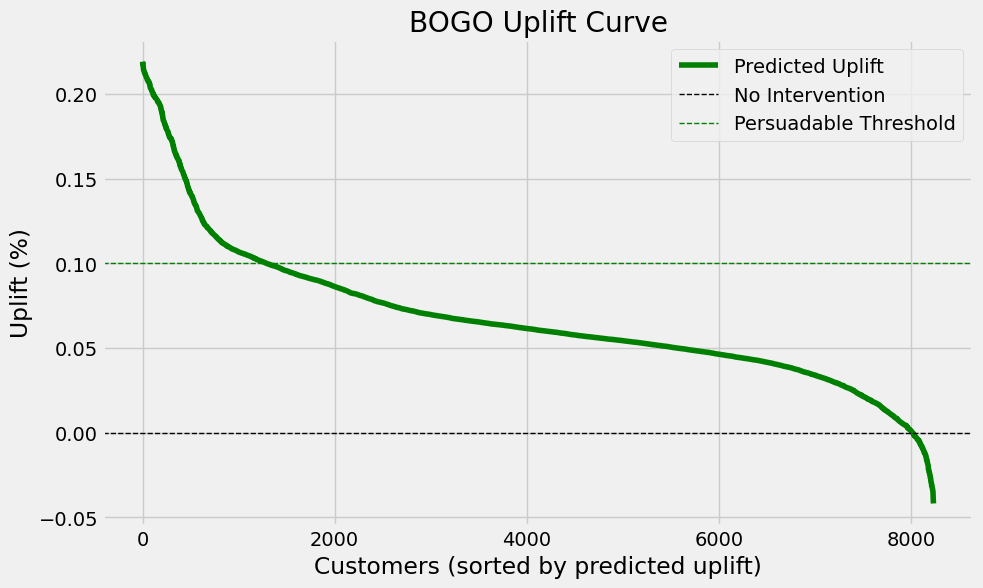

In [78]:
import matplotlib.pyplot as plt

# Assuming you have a DataFrame called uplift_df with a column 'uplift'
# and it's already sorted from lowest to highest uplift

plt.figure(figsize=(10, 6))

# Plot uplift as a line (or points if you prefer)
plt.plot(bogo_preds['preds'].values, color='green', label='Predicted Uplift')

# Add the zero line
plt.axhline(0, color='black', linestyle='--', linewidth=1, label='No Intervention')
plt.axhline(.1, color='green', linestyle='--', linewidth=1, label='Persuadable Threshold')

# Labels and title
plt.xlabel('Customers (sorted by predicted uplift)')
plt.ylabel('Uplift (%)')
plt.title('BOGO Uplift Curve')
plt.legend()

plt.show()


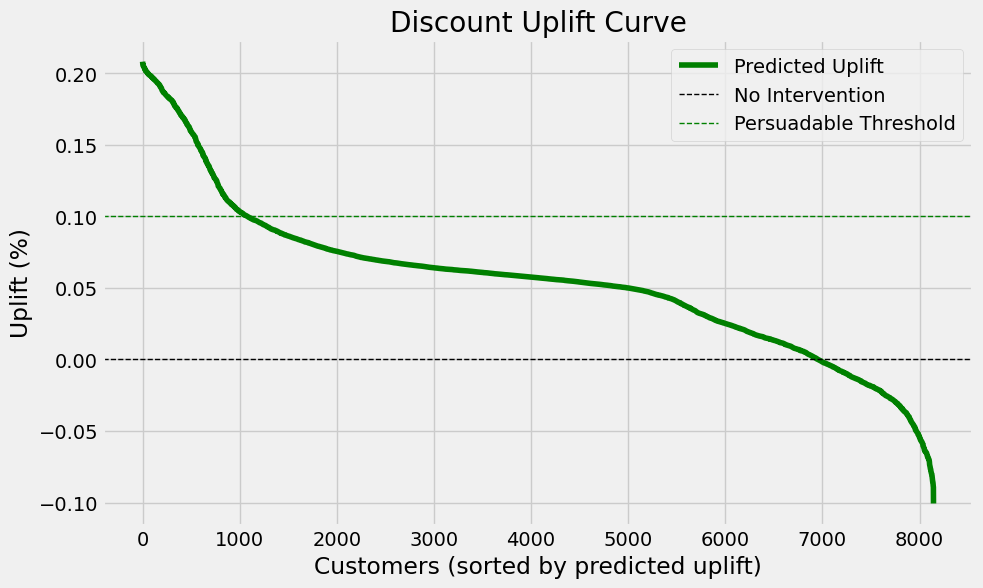

In [79]:
# Assuming you have a DataFrame called uplift_df with a column 'uplift'
# and it's already sorted from lowest to highest uplift

plt.figure(figsize=(10, 6))

# Plot uplift as a line (or points if you prefer)
plt.plot(discount_preds['preds'].values, color='green', label='Predicted Uplift')

# Add the zero line
plt.axhline(0, color='black', linestyle='--', linewidth=1, label='No Intervention')
plt.axhline(.1, color='green', linestyle='--', linewidth=1, label='Persuadable Threshold')

# Labels and title
plt.xlabel('Customers (sorted by predicted uplift)')
plt.ylabel('Uplift (%)')
plt.title('Discount Uplift Curve')
plt.legend()

plt.show()

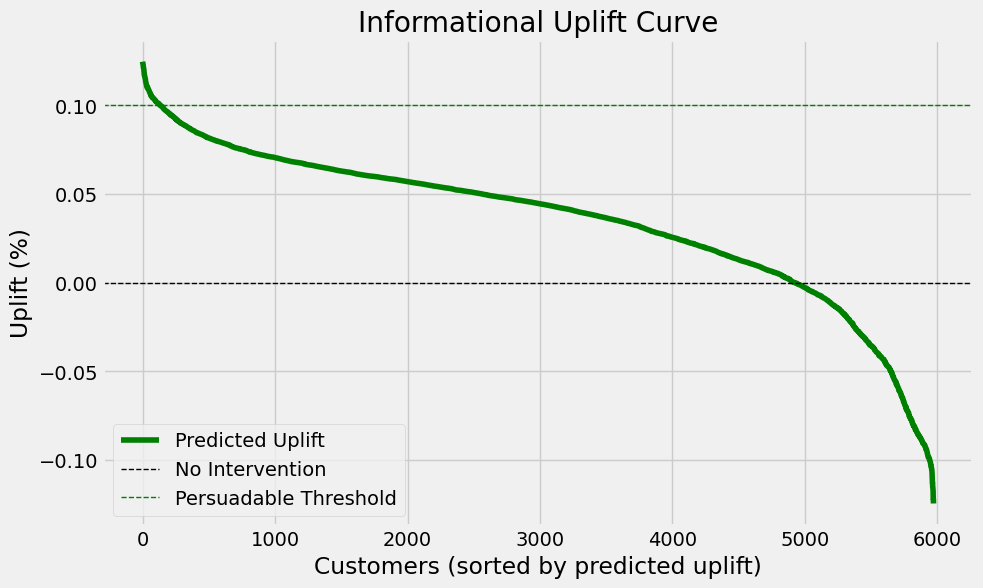

In [80]:
plt.figure(figsize=(10, 6))

# Plot uplift as a line (or points if you prefer)
plt.plot(informational_preds['preds'].values, color='green', label='Predicted Uplift')

# Add the zero line
plt.axhline(0, color='black', linestyle='--', linewidth=1, label='No Intervention')
plt.axhline(.1, color='green', linestyle='--', linewidth=1, label='Persuadable Threshold')

# Labels and title
plt.xlabel('Customers (sorted by predicted uplift)')
plt.ylabel('Uplift (%)')
plt.title('Informational Uplift Curve')
plt.legend()

plt.show()

In [81]:
# set thresholds
def categorize(row):
    if row['preds'] > 0.10:
        return 'Persuadable'
    elif row['preds'] < -0.05:
        return 'Do Not Disturb'
    else:
        return 'Sure Thing/Lost Cause'

bogo_preds['category'] = bogo_preds.apply(categorize, axis=1)
bogo_preds


,person,treatment,recency,frequency,Unnamed: 0,age,income,join_date,purchase_next_week,offer_type,difficulty,reward,gender_M,preds,category
14769,71a5dd25d3704dafa598b9cc2ca7028a,0,168.0,0.0,11901.0,68.0,104000.0,20161016.0,1.0,no_offer,0.0,0.0,False,0.219009,Persuadable
2987,29655cba61a04d079efde18203b4f232,1,168.0,0.0,14281.0,67.0,101000.0,20161017.0,1.0,bogo,5.0,5.0,False,0.218432,Persuadable
15340,e4c1df33299b4b9d9d8924a45823095d,1,168.0,0.0,7489.0,61.0,113000.0,20161105.0,1.0,bogo,5.0,5.0,False,0.217575,Persuadable
12966,40bc3cf593394618b90f6d79e198867a,0,168.0,0.0,3101.0,64.0,109000.0,20161112.0,0.0,no_offer,0.0,0.0,False,0.217566,Persuadable
4014,546267273d6041f48946369c65c11531,1,168.0,0.0,8911.0,62.0,103000.0,20161213.0,1.0,bogo,10.0,10.0,True,0.217555,Persuadable
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13663,a4ecd1ebb16a4800bdbf57aaf0144078,0,168.0,0.0,4468.0,43.0,93000.0,20180711.0,0.0,no_offer,0.0,0.0,True,-0.038093,Sure Thing/Lost Cause
11796,0fa86ae026dc4ed3a9ec0f4676239e9d,1,168.0,0.0,14786.0,47.0,89000.0,20180506.0,0.0,bogo,10.0,10.0,True,-0.038988,Sure Thing/Lost Cause
6612,7e567d349dee4ca6a85805cff8b65c35,1,168.0,0.0,3305.0,49.0,81000.0,20180721.0,1.0,bogo,5.0,5.0,True,-0.039701,Sure Thing/Lost Cause
15794,5cc737397b384d559a097db907980242,1,168.0,0.0,8964.0,49.0,83000.0,20180613.0,1.0,bogo,10.0,10.0,True,-0.039826,Sure Thing/Lost Cause


In [82]:
bogo_preds["category"].value_counts()

category
Sure Thing/Lost Cause    6947
Persuadable              1289
Name: count, dtype: int64

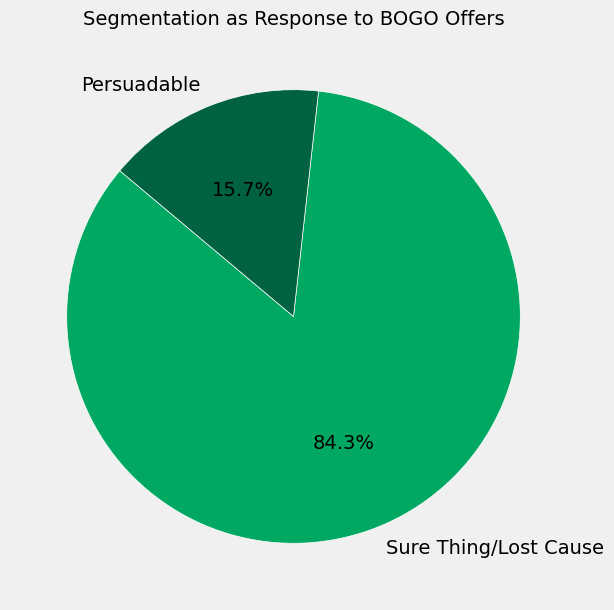

In [83]:
import matplotlib.pyplot as plt

# data
sizes = bogo_preds['category'].value_counts().values
labels = bogo_preds['category'].value_counts().index

# starbucks-inspired colors
colors = ['#00A862', '#006241', '#B6D7B9']

plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, wedgeprops={'edgecolor': 'white'})

plt.title('Segmentation as Response to BOGO Offers', fontsize=14)
plt.show()


In [84]:
discount_preds['category'] = discount_preds.apply(categorize, axis=1)
discount_preds

,person,treatment,recency,frequency,Unnamed: 0,age,income,join_date,purchase_next_week,offer_type,difficulty,reward,gender_M,preds,category
4752,55f752ed98374cc8bc85126766e66236,1,168.0,0.0,15730.0,63.0,104000.0,20160328.0,1.0,discount,20.0,5.0,True,0.208142,Persuadable
13,76e4c32f141f4bd1b1a905cf6b28bcfa,0,168.0,0.0,7094.0,60.0,104000.0,20170508.0,0.0,no_offer,0.0,0.0,False,0.207305,Persuadable
15671,abf29a94ba3d4648869ad7505d863e22,0,168.0,0.0,1378.0,62.0,98000.0,20160502.0,0.0,no_offer,0.0,0.0,False,0.206721,Persuadable
5431,aebb936affe9484e971a033e901eea7d,0,168.0,0.0,10913.0,62.0,102000.0,20160323.0,0.0,no_offer,0.0,0.0,False,0.206061,Persuadable
10688,5cccab62e4f3456f9824f1930e1da5dc,0,168.0,0.0,3823.0,62.0,101000.0,20160406.0,0.0,no_offer,0.0,0.0,False,0.206061,Persuadable
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13748,5dc074a4f3e54a51965feaada51c0bd8,1,168.0,0.0,8020.0,58.0,84000.0,20180725.0,1.0,discount,10.0,2.0,True,-0.087425,Do Not Disturb
13076,461c8478728a47969f3b97b406b274cc,1,168.0,0.0,2745.0,49.0,114000.0,20180514.0,0.0,discount,20.0,5.0,True,-0.087886,Do Not Disturb
645,d41fa9b8c2e24a1d94caa890c53bbcf6,0,168.0,0.0,656.0,53.0,95000.0,20180609.0,0.0,no_offer,0.0,0.0,True,-0.088861,Do Not Disturb
12423,c765dc1f59bb44c1b80bef39a34ceeaa,1,168.0,0.0,6030.0,61.0,92000.0,20180617.0,0.0,discount,10.0,2.0,True,-0.089185,Do Not Disturb


In [85]:
discount_preds['category'].value_counts()

category
Sure Thing/Lost Cause    6887
Persuadable              1079
Do Not Disturb            179
Name: count, dtype: int64

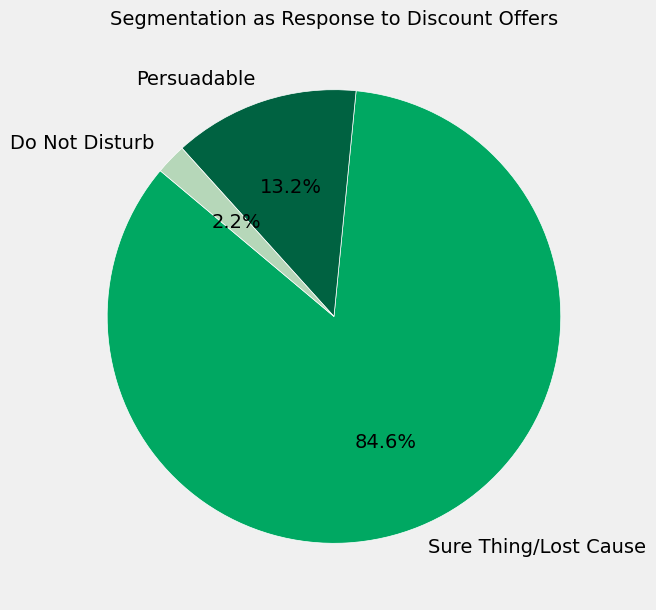

In [86]:
# data
sizes = discount_preds['category'].value_counts().values
labels = discount_preds['category'].value_counts().index

# starbucks-inspired colors
colors = ['#00A862', '#006241', '#B6D7B9']

plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, wedgeprops={'edgecolor': 'white'})

plt.title('Segmentation as Response to Discount Offers', fontsize=14)
plt.show()

In [87]:
informational_preds['category'] = informational_preds.apply(categorize, axis=1)
informational_preds

,person,treatment,recency,frequency,Unnamed: 0,age,income,join_date,purchase_next_week,offer_type,difficulty,reward,gender_M,preds,category
10949,522c3cb8b22e4b1daa25ebf62d22645f,0,168.0,0.0,957.0,53.0,95000.0,20180117.0,0.0,no_offer,0.0,0.0,False,0.124734,Persuadable
9298,3a50b4edf0294d22b5a3400e349cb0a6,0,168.0,0.0,13222.0,49.0,112000.0,20180131.0,0.0,no_offer,0.0,0.0,False,0.124069,Persuadable
13006,841b3d5eb0c4435e95161cb47da4e0d7,1,168.0,0.0,9849.0,51.0,84000.0,20171231.0,1.0,informational,0.0,0.0,False,0.123738,Persuadable
3307,9cff5cba68bb44b5baeb3d18c424297c,0,168.0,0.0,7157.0,50.0,88000.0,20171225.0,1.0,no_offer,0.0,0.0,False,0.123407,Persuadable
9625,a24f1f58f75a442c946fe7659cfd6112,0,168.0,0.0,12590.0,51.0,105000.0,20171211.0,0.0,no_offer,0.0,0.0,False,0.123015,Persuadable
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13216,dc9be5a796834821a41aaa2393e5a8d9,0,168.0,0.0,4634.0,45.0,61000.0,20180722.0,1.0,no_offer,0.0,0.0,False,-0.116623,Do Not Disturb
5615,6cbc092fb84a437f9a248420129ca1f2,0,168.0,0.0,6456.0,50.0,63000.0,20180616.0,1.0,no_offer,0.0,0.0,False,-0.117396,Do Not Disturb
1472,fb75504a0e404549995a3e8427a2a252,0,168.0,0.0,8152.0,48.0,64000.0,20180726.0,1.0,no_offer,0.0,0.0,False,-0.121889,Do Not Disturb
1307,42f00b6b150e45149c50db9bd642bca6,0,168.0,0.0,13249.0,45.0,70000.0,20180726.0,0.0,no_offer,0.0,0.0,False,-0.121908,Do Not Disturb


In [88]:
informational_preds["category"].value_counts()

category
Sure Thing/Lost Cause    5513
Do Not Disturb            322
Persuadable               137
Name: count, dtype: int64

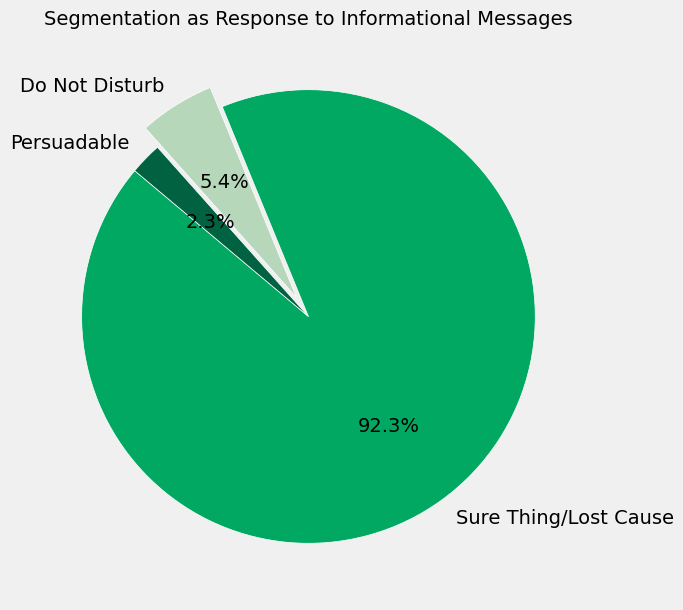

In [89]:
# data
sizes = informational_preds['category'].value_counts().values
labels = informational_preds['category'].value_counts().index

# starbucks-inspired colors
colors = ['#00A862', '#B6D7B9', '#006241']
explode = [0.1 if label == 'Do Not Disturb' else 0 for label in labels]

# pie chart
plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, explode=explode, wedgeprops={'edgecolor': 'white'})


plt.title('Segmentation as Response to Informational Messages', fontsize=14)
plt.show()